# Unet Evaluation Cockpit

## Import modules and set up GPU

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time
import h5py
from tqdm import tqdm
from importlib import reload
import itertools

import tensorflow as tf

In [2]:
# Import modules providing tools for image manipulation
import sys
sys.path.append('../tools')
import tilingStrategy, Dataset3D, visualization
sys.path.append('..')
import utilities, model, metrics
reload(utilities)
reload(Dataset3D) 

<module 'Dataset3D' from '../tools\\Dataset3D.py'>

In [27]:
saveDir = 'D:\\Janelia\\UnetTraining\\GapFilledMaskNetwork\\20200927_maskComparison\\evalUnseen\\'

In [4]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Load a dataset containing the evaluation data

In [5]:
base_dir = 'D:\\Janelia\\UnetTraining\\Evaluation\\'
dataset_path = base_dir+'20200928_eval.h5'
dataset = Dataset3D.Dataset(dataset_path) # The Dataset3D class handles all file level i/o operations

print('Dataset {} contains {} records'.format(dataset, len(dataset)))

print('Dataset metadata entries:')
print(dataset.getAttributes().keys())

../tools\Dataset3D.py:134: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.dataset_h5 = h5py.File(dataset_path)


Opened dataset with 199 preexisting items. Overwriting items with the same name.
Dataset <Dataset3D.Dataset object at 0x00000235F0A05AC8> contains 199 records
Dataset metadata entries:
<KeysViewHDF5 []>


In [6]:
# get a list of all records in the database
entries = list(dataset.keys())
# shuffle entries
np.random.shuffle(entries)

# Make a train test split and retrieve a callable -> that produces a generator -> that yields the recods specified by the key list in random order
n_val = 50 # set aside 30 examples for validation
subset = entries[:n_val]
print(subset)

['Q252', 'Q2145', 'Q2172', 'Q2138', 'Q239', 'R1120', 'R1112', 'Q1232', 'Q1106', 'R193', 'Q1135', 'R1105', 'Q154', 'Q2207', 'Q146', 'Q2230', 'Q2167', 'R2136', 'R1107', 'Q197', 'R1119', 'R282', 'Q110', 'Q1211', 'R2244', 'Q1148', 'Q173', 'R1246', 'Q2164', 'R2166', 'Q246', 'R1122', 'R2135', 'Q2154', 'R290', 'Q2158', 'R1178', 'R243', 'Q1209', 'R1114', 'Q2206', 'R176', 'Q2162', 'Q164', 'Q2155', 'R2145', 'R2226', 'R1244', 'R2228', 'R111']


In [7]:
# For better reproducability reuse the keys from an earlier run
subset = ['R1107', 'R2237', 'Q1205', 'R2131', 'R2172', 'R235', 'Q2171', 'R1128', 'R270', 'Q252', 'Q1149', 'R1244', 'R2136', 'R2185', 'R2146', 'Q2239', 'R1215', 'R230', 'R198', 'R272', 'R2160', 'R1124', 'R1120', 'Q2158', 'R252', 'R1114', 'R274', 'Q154', 'Q2147', 'Q292', 'Q1148', 'Q151', 'Q2247', 'R1154', 'Q2186', 'R290', 'R161', 'Q12', 'Q1122', 'R1118', 'Q2154', 'Q1176', 'R251', 'Q2155', 'Q2145', 'R1187', 'R2145', 'R140', 'R2173', 'Q1142']

In [8]:
# Just use the random subset generated above or reuse the keys of another run for comparability
samples = dataset.getGenerator(subset)

# Instantiate tf Datasets from the generator producing callables, specify the datatype and shape of the generator output
validationset_raw = tf.data.Dataset.from_generator(samples, 
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape([220,220,220]),tf.TensorShape([220,220,220])))

In [9]:
# each entry is preprocessed by passing it through this function
# EXPECT normalized image chanel !
# EXPECT binarized masks
def preprocess(x,y):
    x = tf.expand_dims(x, axis=-1) # The unet expects the input data to have an additional channel axis.
    y = tf.one_hot(y, depth=2, dtype=tf.int32) # one hot encode to int tensor
    return x, y

# Crop
def crop_mask(x, y, mask_size=(132,132,132)):
    # apply crop after batch dimension is added x and y have (b,x,y,z,c) format while mask size has (x,y,z) format => add offset of 1
    crop = [(y.shape[d+1]-mask_size[d])//2 for d in range(3)]
    #keras implicitly assumes channels last format
    y = tf.keras.layers.Cropping3D(cropping=crop)(y)
    return x, y

validationset = validationset_raw.map(preprocess).batch(1).map(crop_mask).prefetch(1)
validationset_iter = iter(validationset)

(1, 220, 220, 220, 1)
(1, 132, 132, 132, 2)


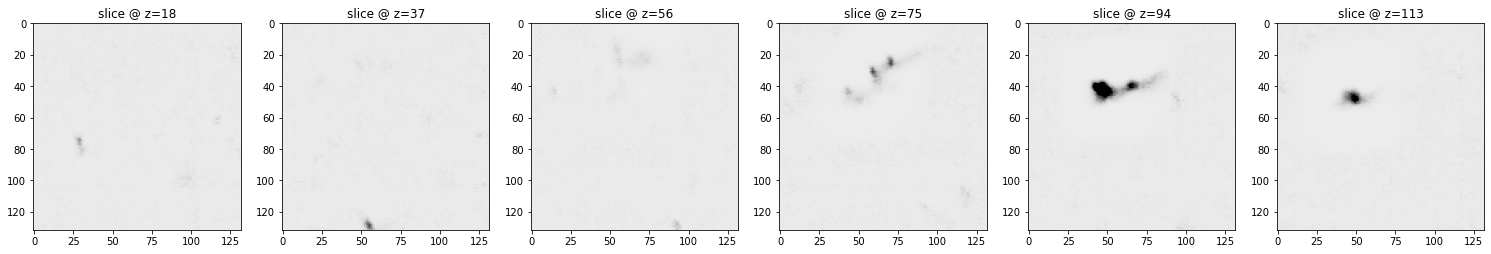

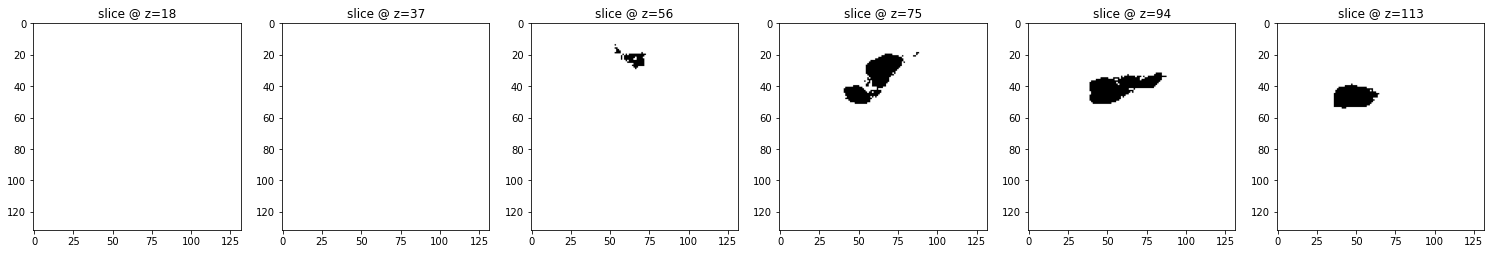

In [20]:
# Visualize an image mask pair from the validation set
im, msk = next(validationset_iter)
print(im.shape)
print(msk.shape)
visualization.showZSlices(im[0,44:176,44:176,44:176,0],channel=None, vmin=-2, vmax=10, n_slices=6)
visualization.showZSlices(msk[0,...,1], channel=None, vmin=0,vmax=1, n_slices=6)

## Load a pretrained model

In [24]:
## Restore a saved model if desired
#model_path = 'C:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\VVDMaskNetwork\\VVDOvermask_0922'
model_path = 'D:\\Janelia\\UnetTraining\\GapFilledMaskNetwork\\20200927_maskComparison\\gapFilled.h5'
# Restore the trained model. Specify where keras can find custom objects that were used to build the unet
unet = tf.keras.models.load_model(model_path, compile=False,
                                  custom_objects={"InputBlock" : model.InputBlock,
                                                    "DownsampleBlock" : model.DownsampleBlock,
                                                    "BottleneckBlock" : model.BottleneckBlock,
                                                    "UpsampleBlock" : model.UpsampleBlock,
                                                    "OutputBlock" : model.OutputBlock})

In [25]:
unet.compile(loss = model.weighted_cce_dice_loss(class_weights=[1,5], dice_weight=0.3),
             metrics=['acc',metrics.MeanIoU(num_classes=2, name='meanIoU')])

In [26]:
## Generate Predictions for the validation dataset

loss, accuracy, iou = unet.evaluate(validationset, verbose=0)

In [28]:
print(accuracy)
print(iou)

0.99120444
0.76808584


26it [00:16,  2.09it/s]../tools\visualization.py:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, n_slices, figsize=(plot_size*n_slices+2,plot_size+0.25))
50it [00:32,  1.52it/s]


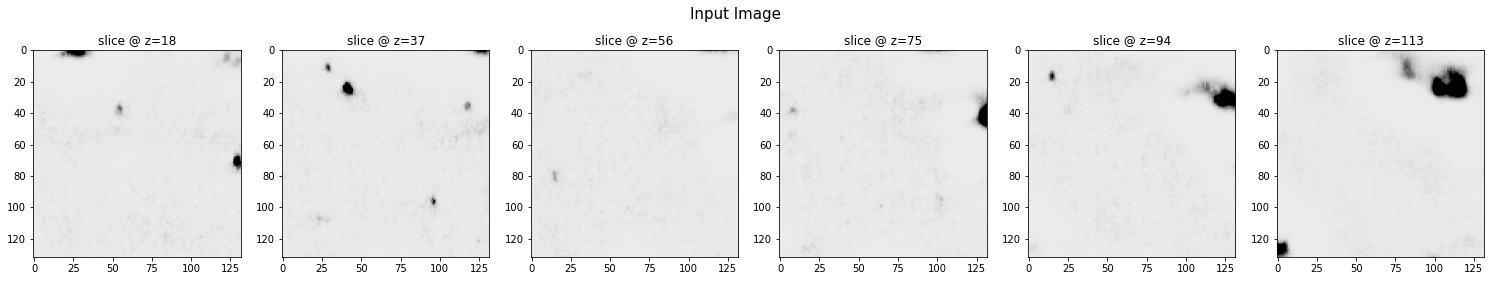

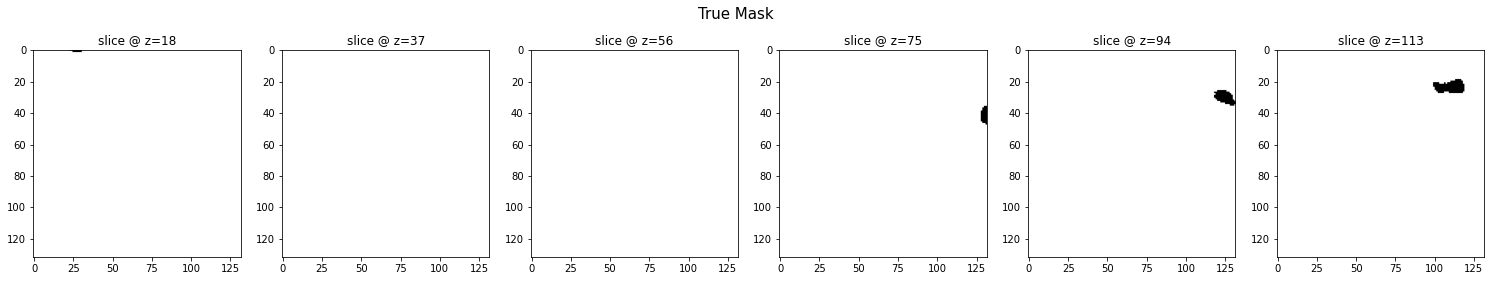

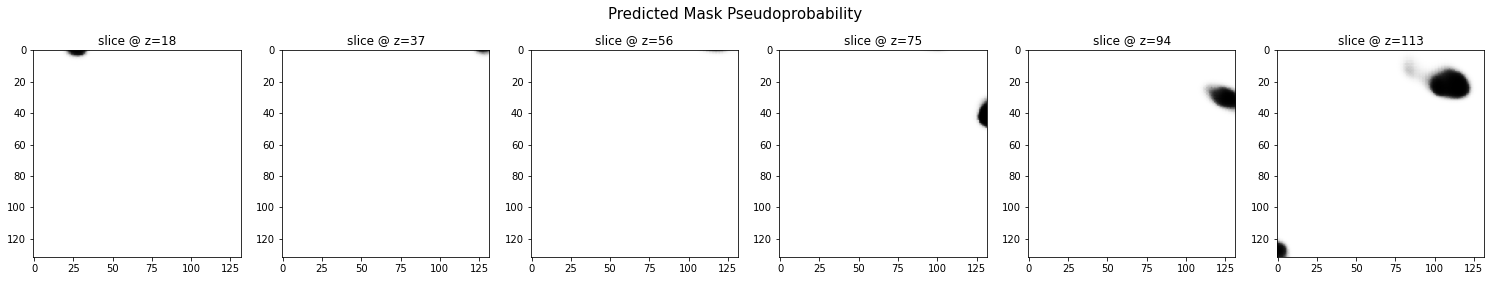

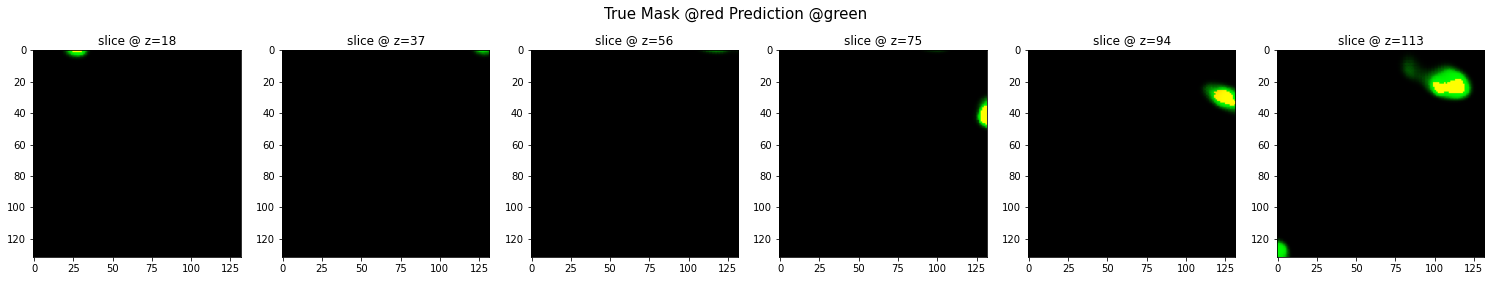

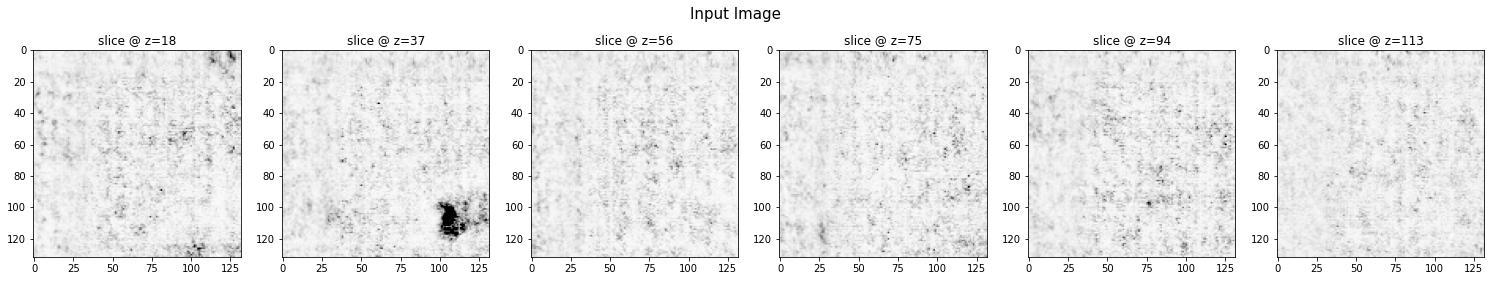

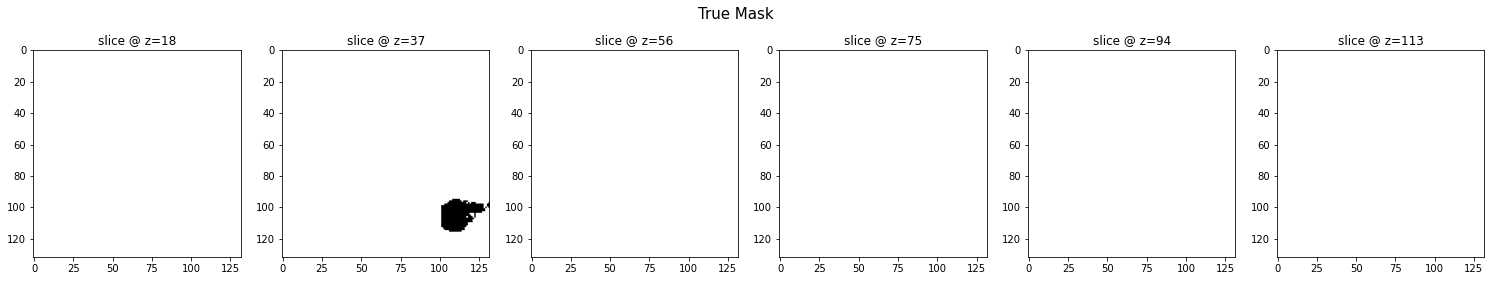

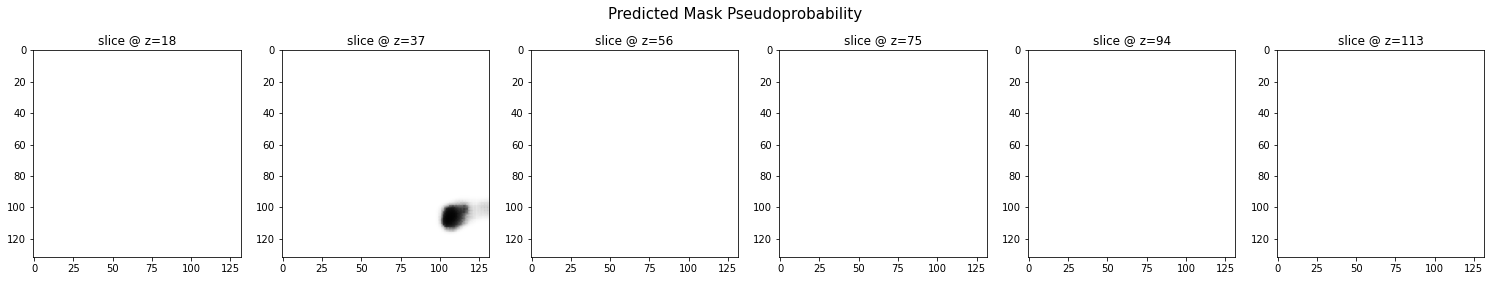

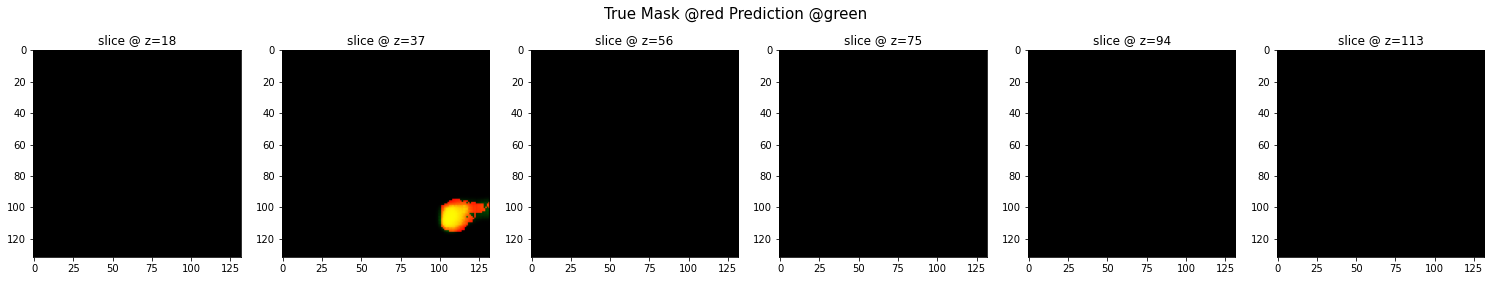

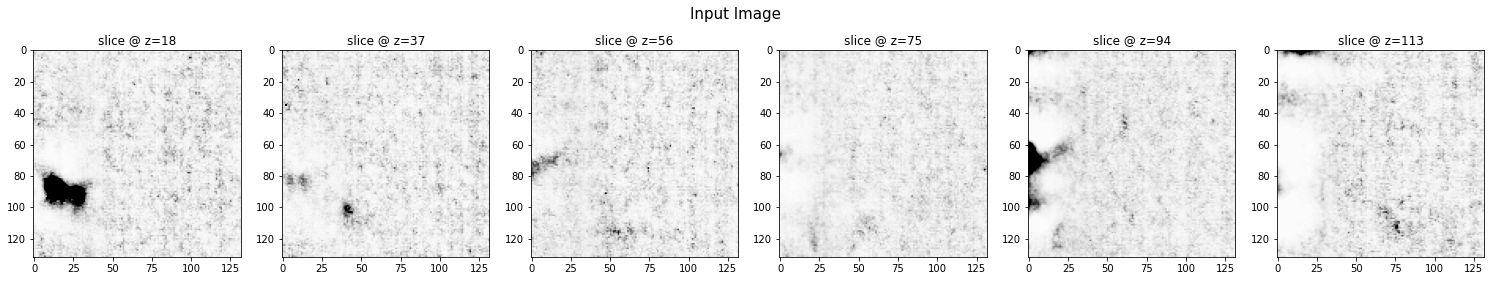

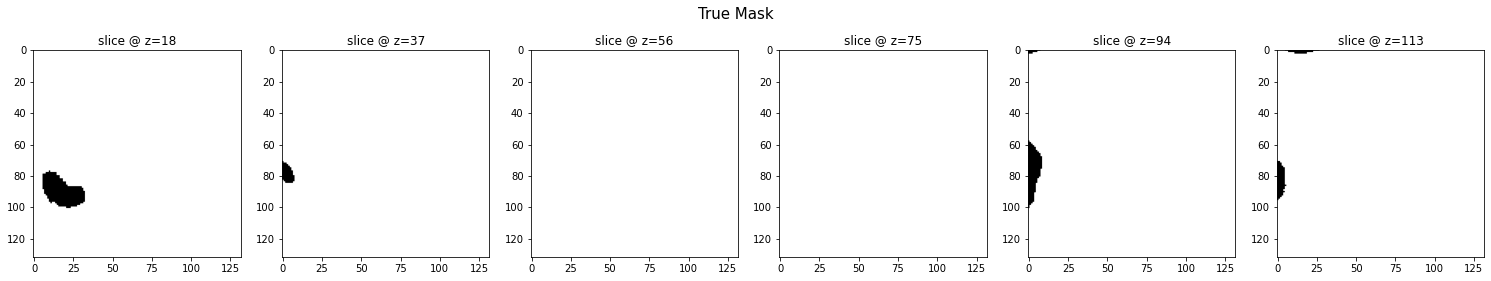

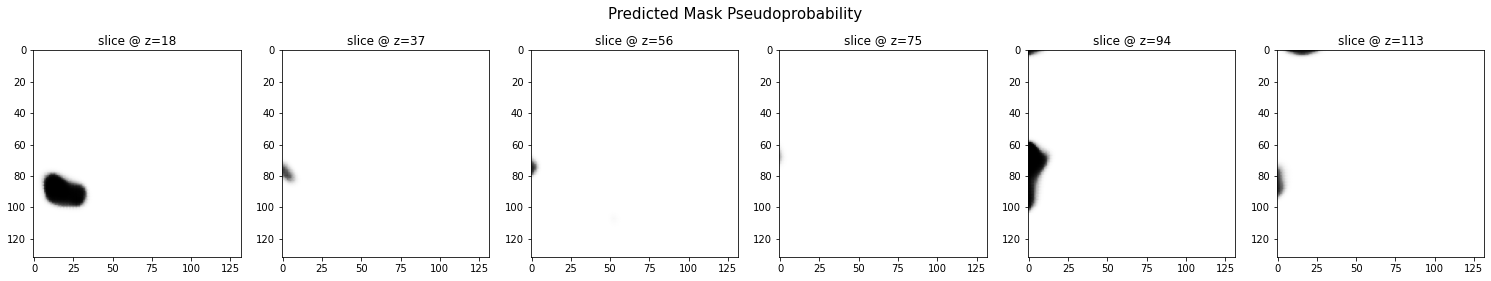

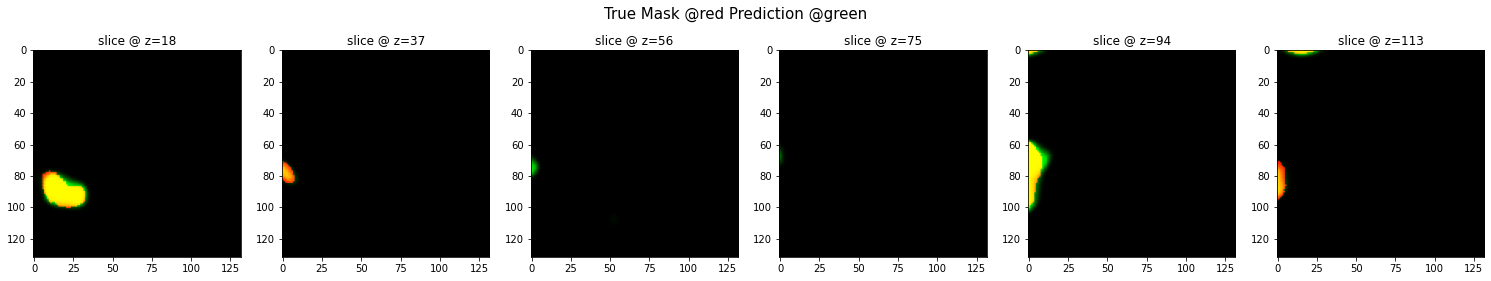

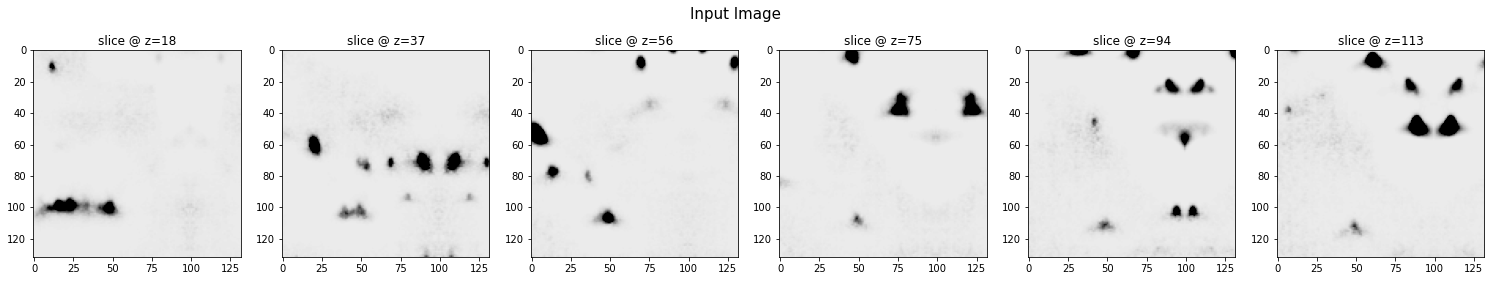

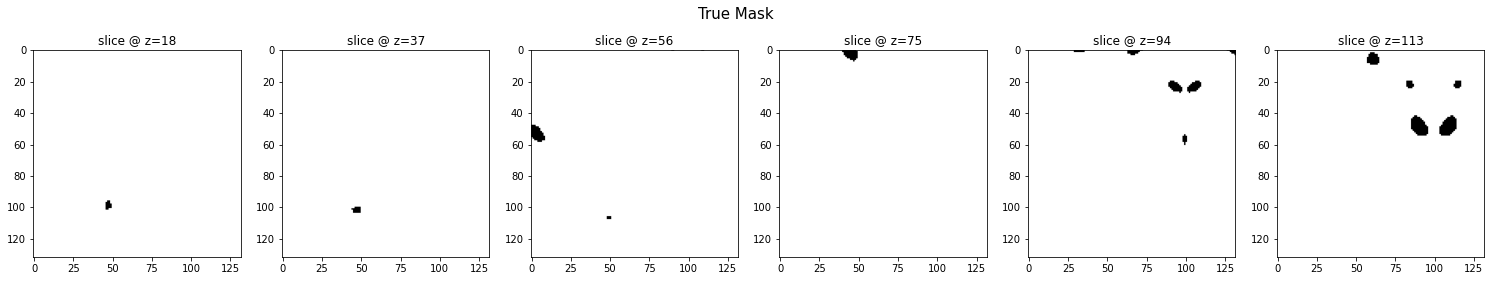

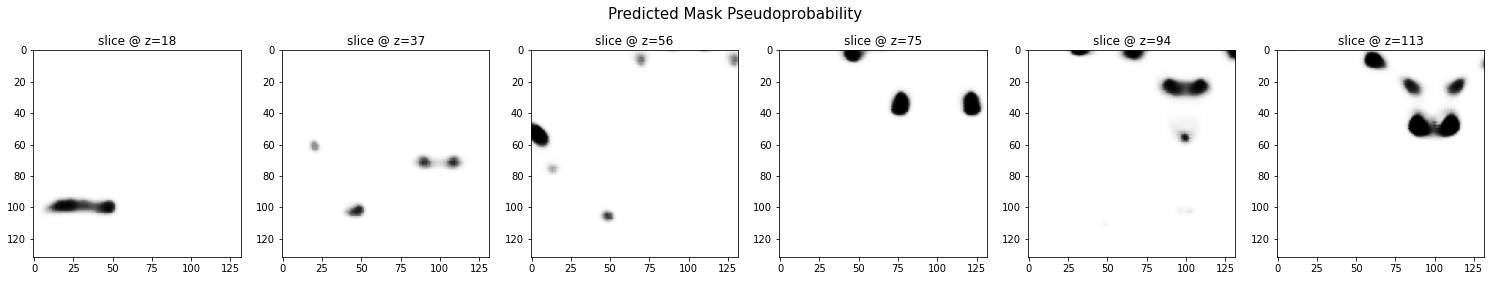

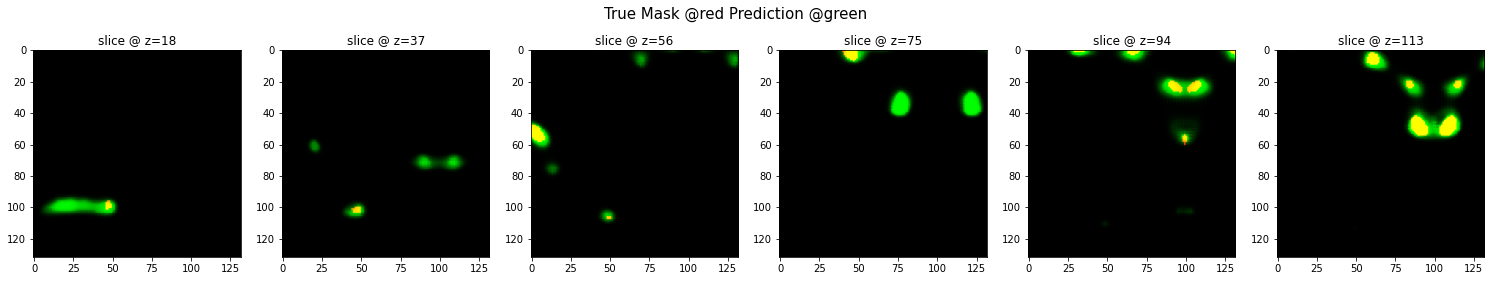

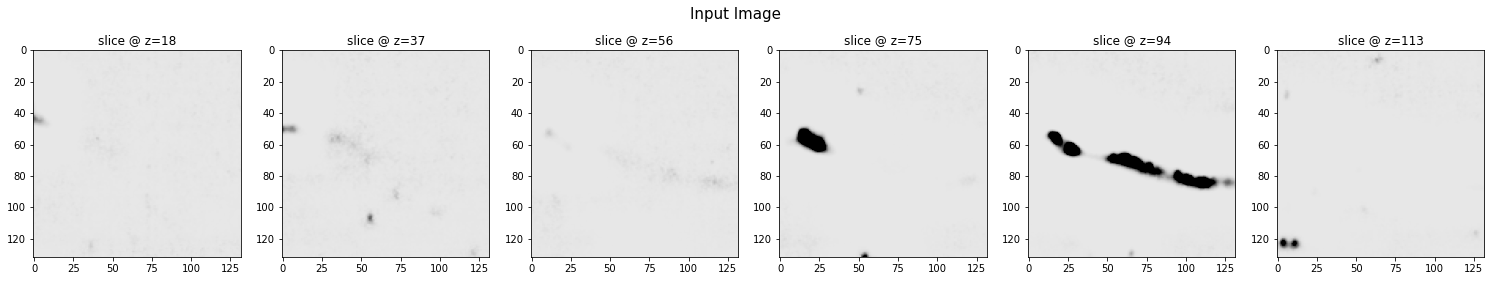

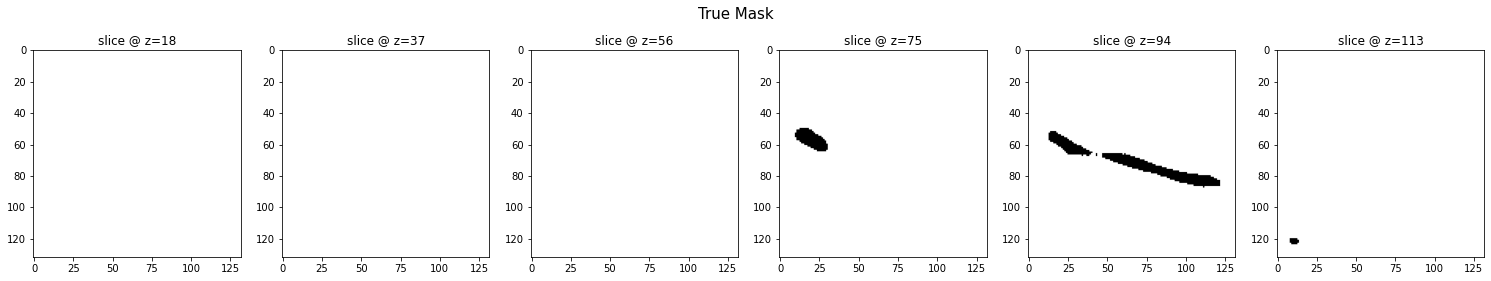

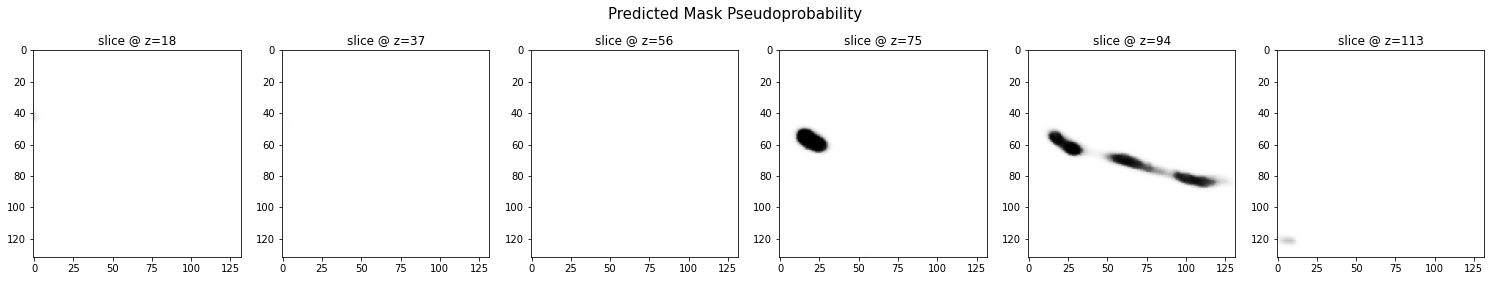

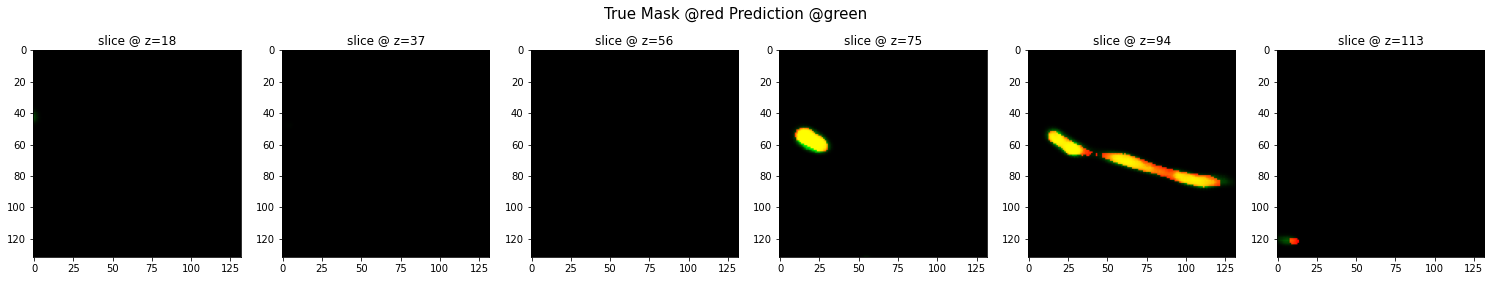

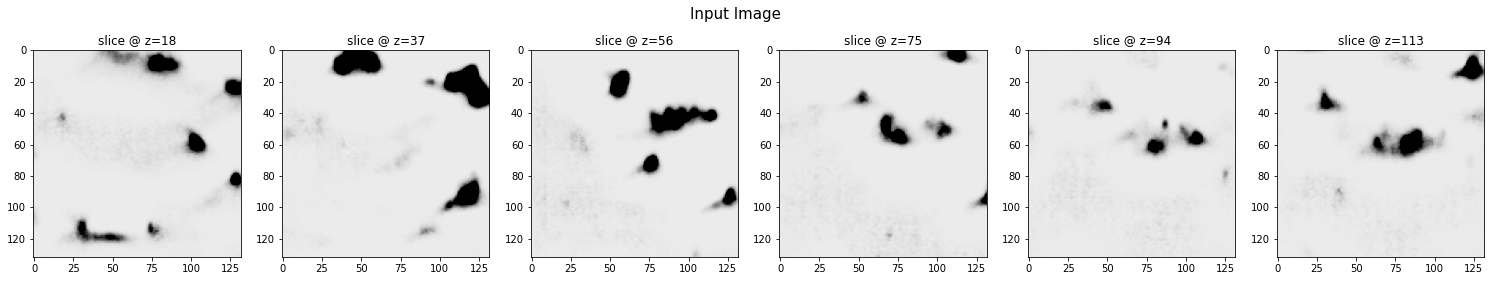

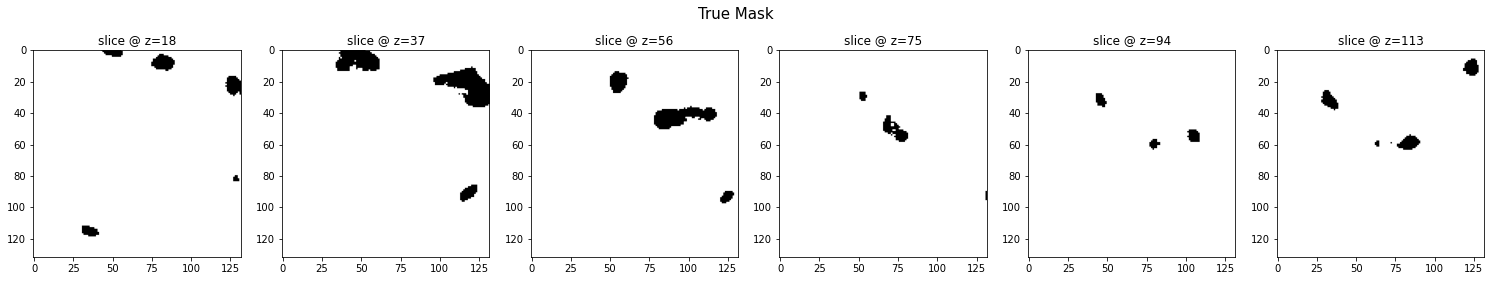

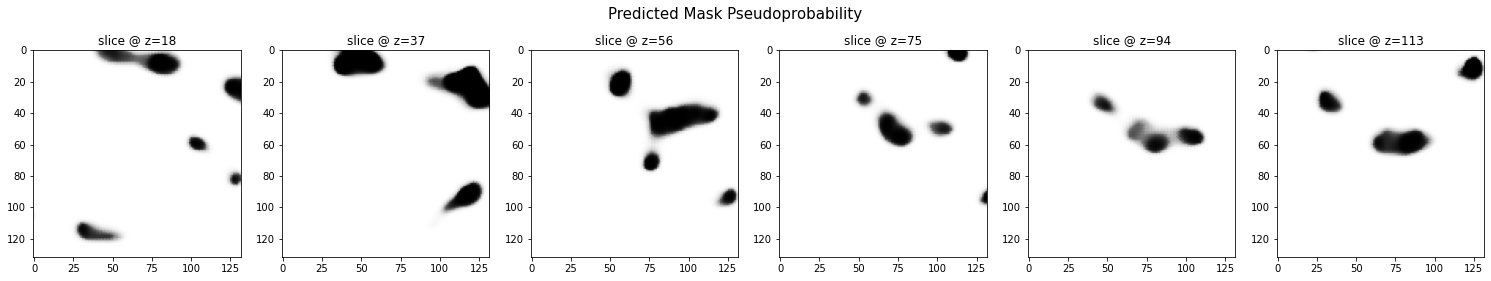

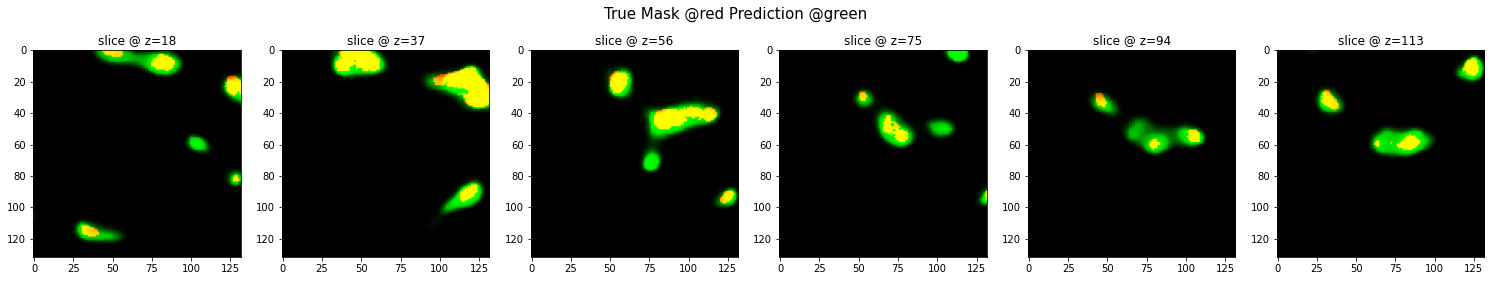

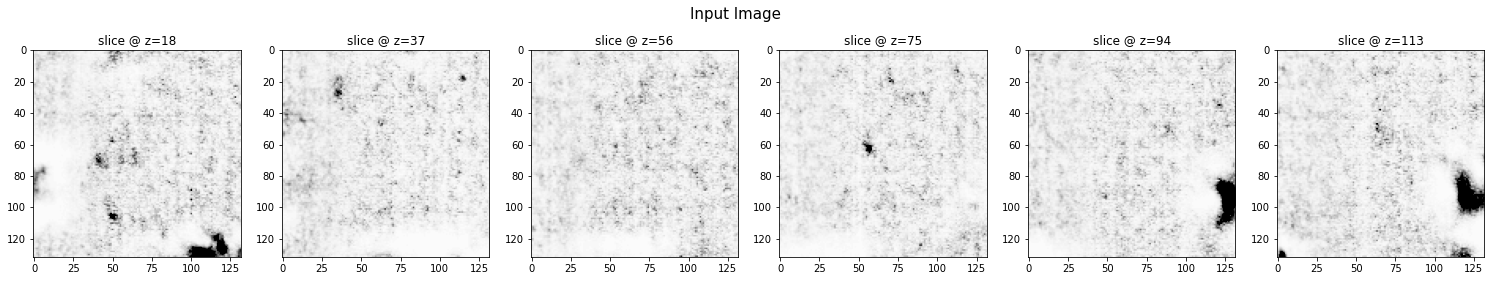

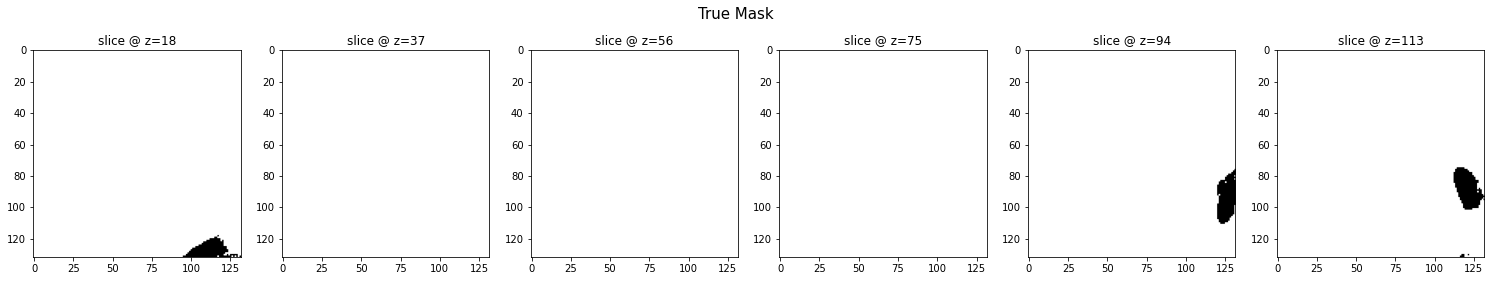

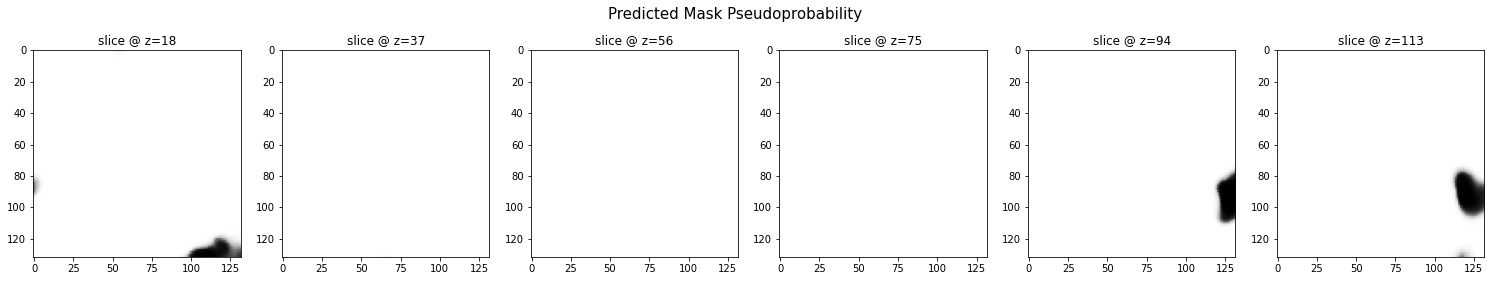

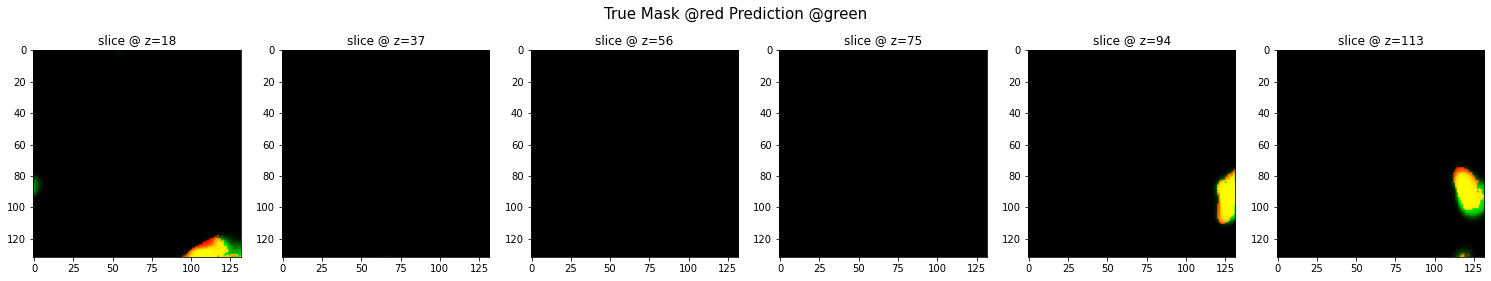

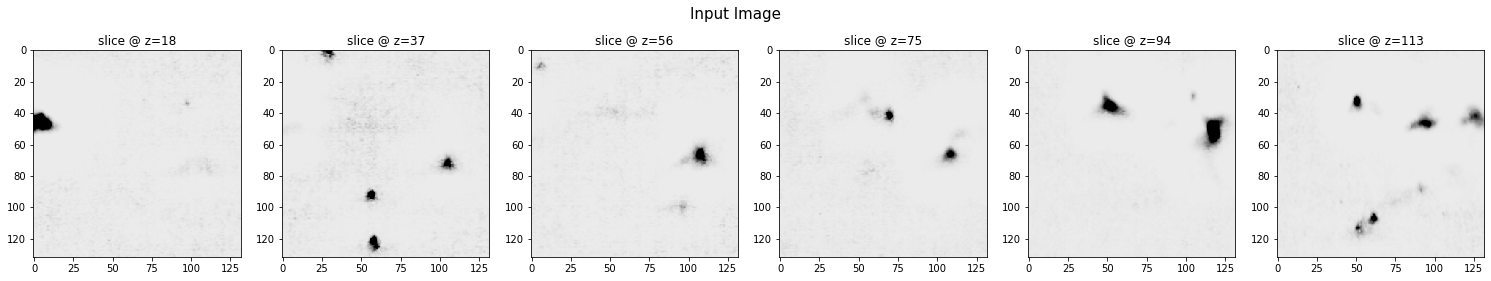

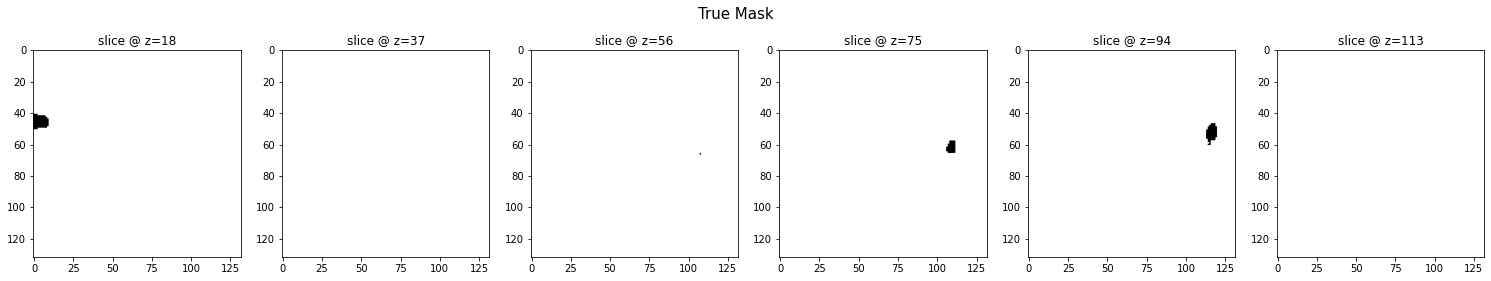

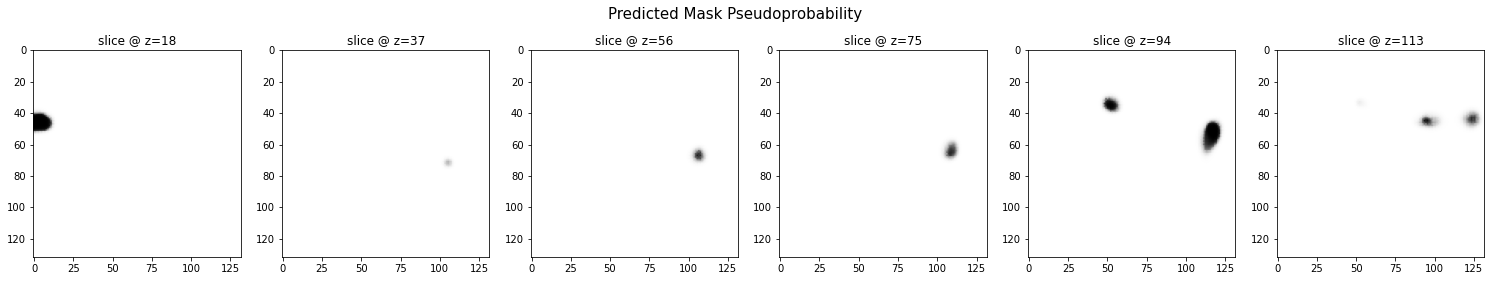

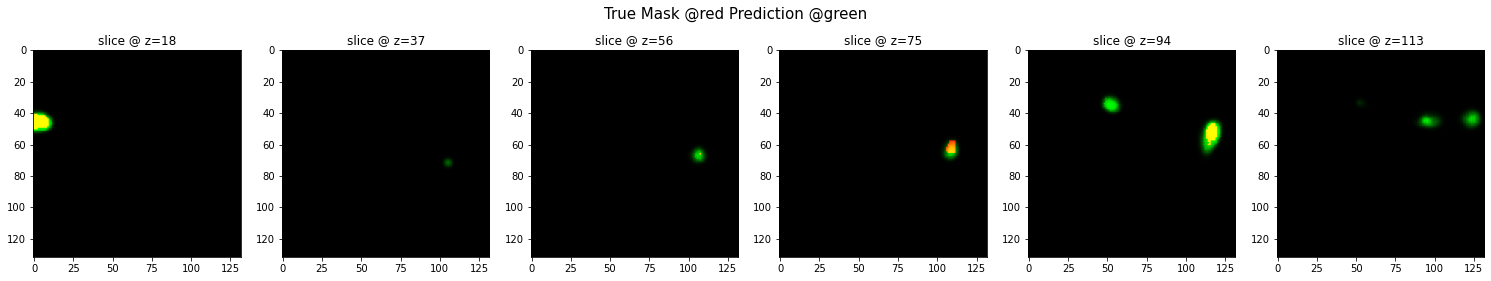

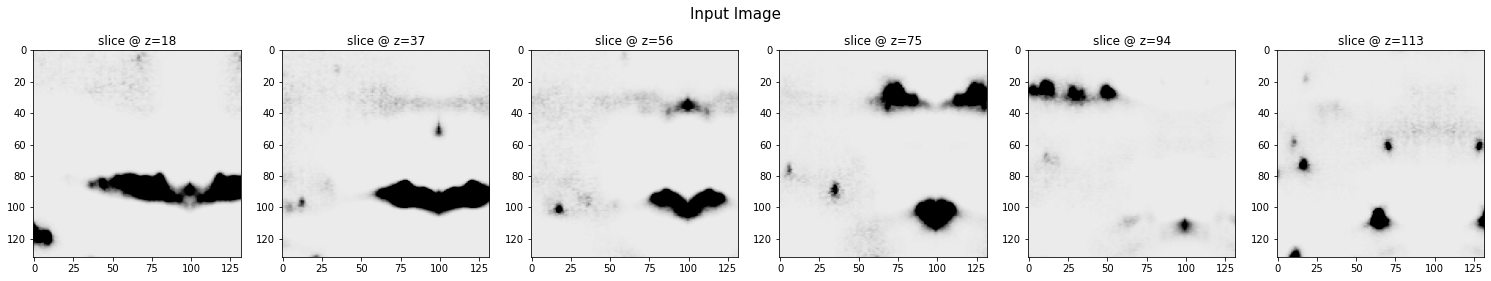

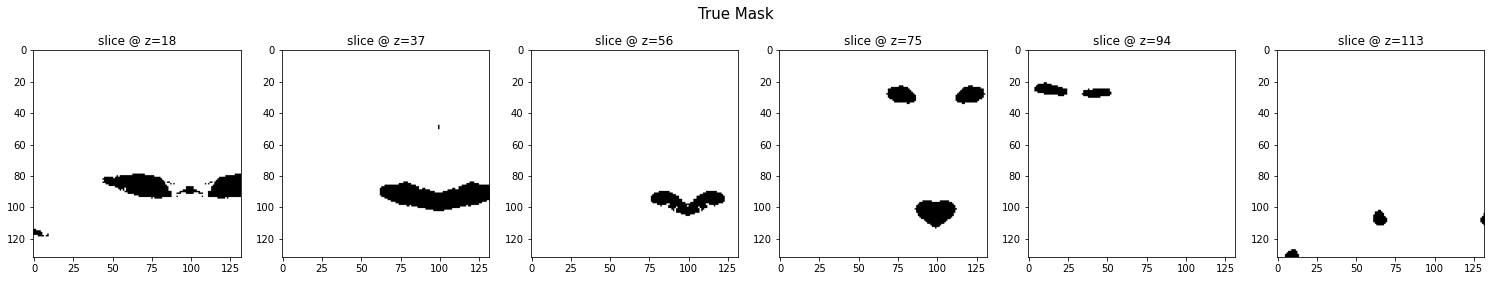

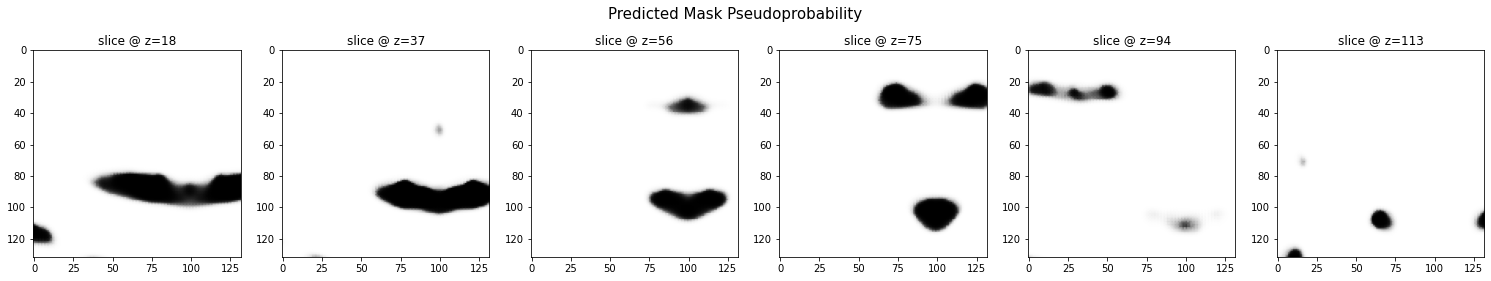

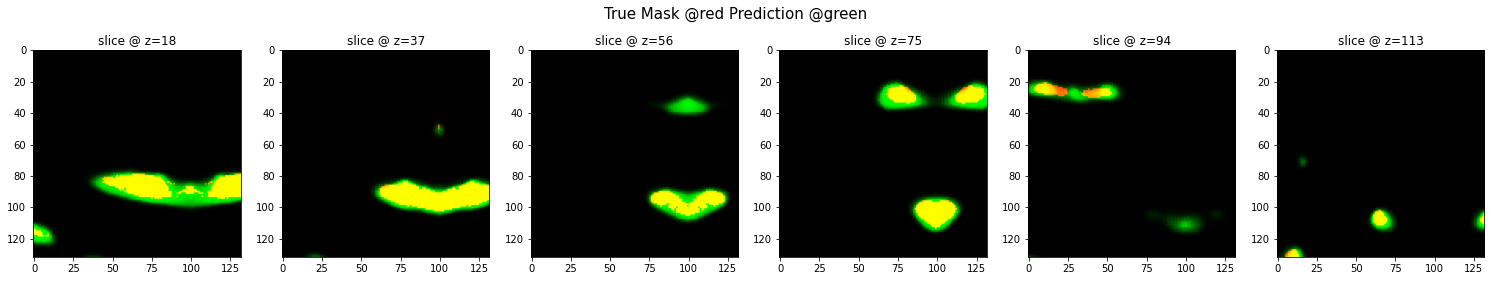

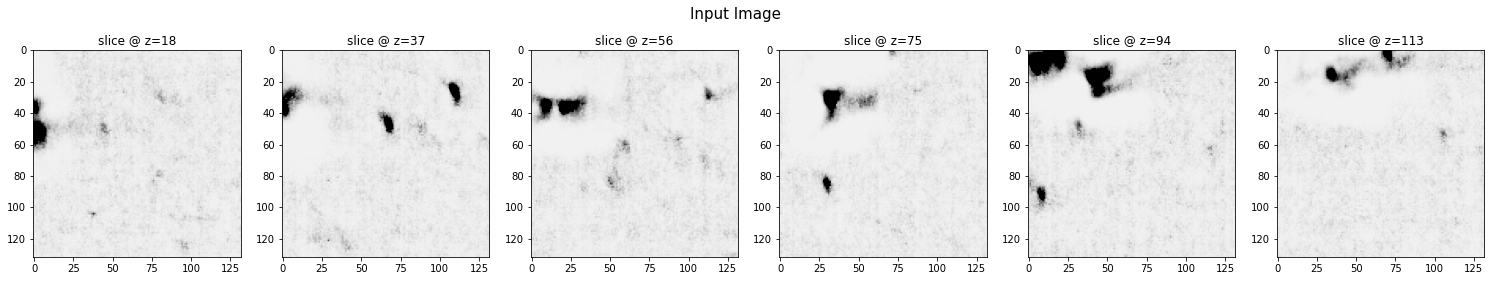

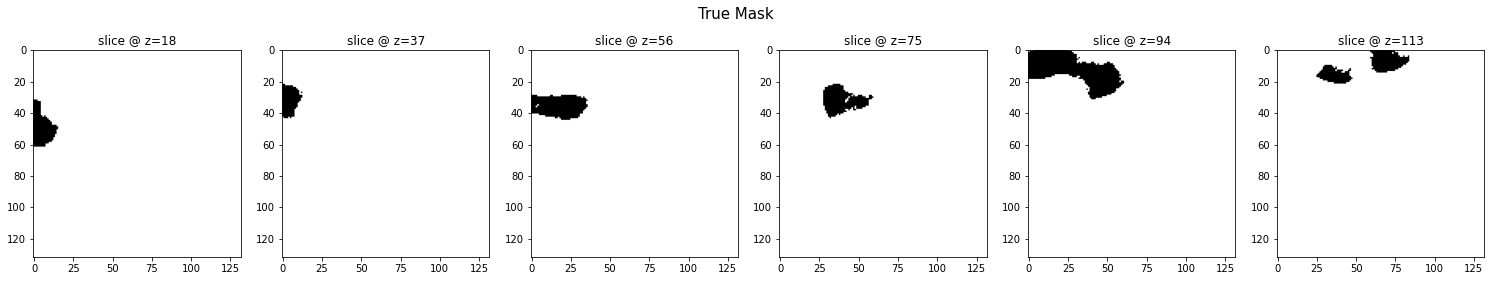

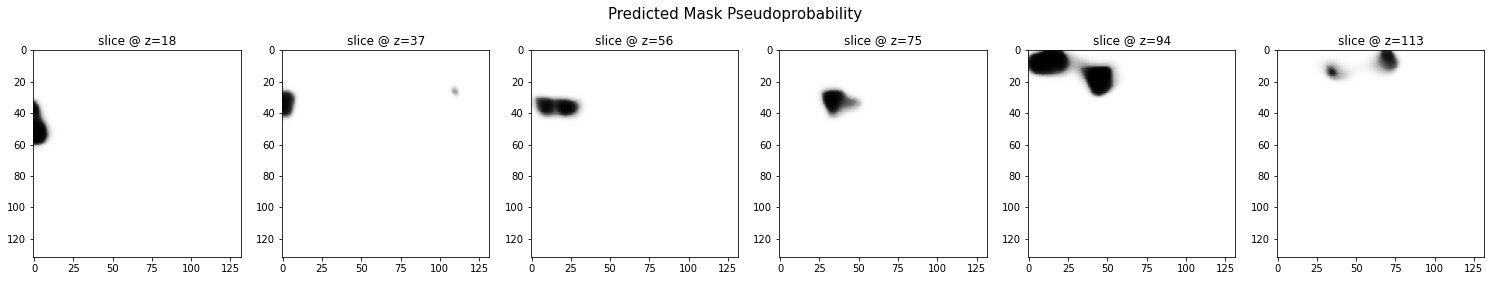

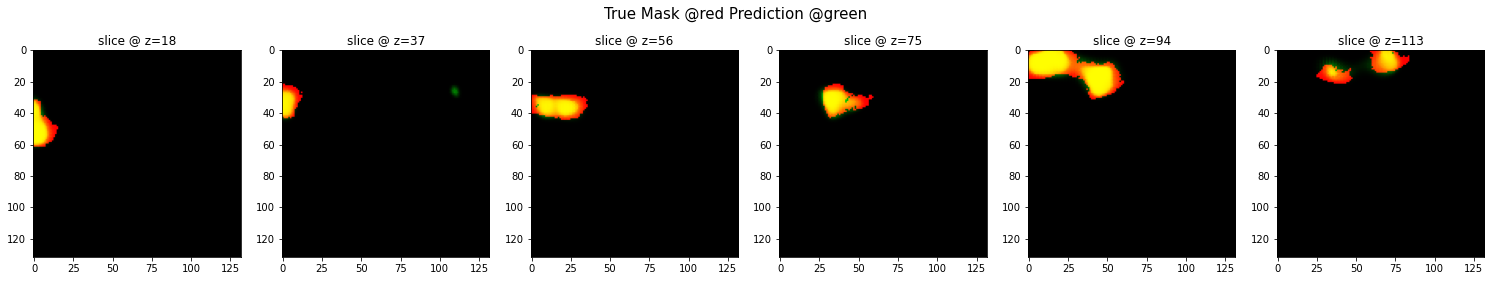

In [32]:
y_true, y_pred = [],[]

validationset_iter = iter(validationset)
for n, (im, msk) in tqdm(enumerate(validationset_iter)):
    # get prediction for image
    pred = unet.predict(im)
    # convert to pseudoprobability
    pred = tf.nn.softmax(pred, axis=-1)
    y_pred.append(pred.numpy()[0,...,1])
    # get binary y_true from mask
    y_true.append(msk.numpy()[0,...,1])
    
    ## visualize some training examples and the unet ouput
    if n%5==1:
        savePath = saveDir+'val_{}'.format(n)
        im = im.numpy()[0,44:176,44:176,44:176,0] # crop image and convert to (x,y,z) format (im is z normalized)
        msk = msk.numpy()[0,...,1] # extract fist channel of mask for vis
        pred = pred.numpy()[0,...,1]
        visualization.showZSlices(im ,channel=None,vmin=-0.5,vmax=2, n_slices=6, title='Input Image', savePath=savePath+'_0_im.png')
        visualization.showZSlices(msk,channel=None,vmin=0,vmax=1, n_slices=6, title='True Mask', savePath=savePath+'_1_true.png')
        visualization.showZSlices(pred,channel=None,vmin=0,vmax=1, n_slices=6, title='Predicted Mask Pseudoprobability', savePath=savePath+'_2_pred.png')
        mask_overlay = visualization.makeRGBComposite(r=msk[...,np.newaxis], g=pred[...,np.newaxis] ,b=None, gain=1.) # Make an overlay of the true mask (red) and the predicted mask (green)
        visualization.showZSlices(mask_overlay,n_slices=6, mode='rgb', title='True Mask @red Prediction @green', savePath=savePath+'_3_overlay.png')
        #mask_overlay = visualization.makeRGBComposite(r=msk[...,np.newaxis], g=pred[...,np.newaxis] ,b=im[...,np.newaxis], gain=(1.,1.,0.5)) # Make an overlay of the true mask (red) and the predicted mask (green)
        #visualization.showZSlices(mask_overlay,n_slices=6, mode='rgb', title='True Mask @red Prediction @green Image @blue')
    
y_true = np.stack(y_true, axis=0)
y_pred = np.stack(y_pred, axis=0)

In [154]:
reload(visualization)

<module 'visualization' from '../tools\\visualization.py'>

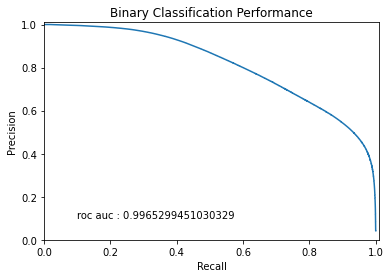

In [30]:
precision, recall, thresholds, auc = metrics.precisionRecall(y_true,y_pred)
plt.figure()
plt.plot(recall,precision)
plt.title('Binary Classification Performance')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1.01])
plt.ylim([0,1.01])
plt.text(0.1,0.1,'roc auc : {}'.format(auc))
plt.savefig(saveDir+'PrecisionRecall.png')

In [190]:
# Get Recall and Precision for a given probability threshold
index = np.sum( thresholds < 0.5 )
recall[index]
precision[index]

In [31]:
print('threshold precision recall')
for t in np.linspace(0,1,21):
    index = np.sum( thresholds < t )
    print('{:.2f} {:.2f} {:.2f}'.format(t,precision[index],recall[index]))

threshold precision recall
0.00 0.04 1.00
0.05 0.40 0.98
0.10 0.44 0.96
0.15 0.47 0.95
0.20 0.49 0.94
0.25 0.52 0.92
0.30 0.54 0.90
0.35 0.56 0.88
0.40 0.58 0.86
0.45 0.60 0.84
0.50 0.61 0.83
0.55 0.62 0.82
0.60 0.64 0.80
0.65 0.65 0.79
0.70 0.66 0.77
0.75 0.68 0.75
0.80 0.71 0.72
0.85 0.74 0.68
0.90 0.78 0.63
0.95 0.84 0.54
1.00 1.00 0.02
